In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import yolonet_model

In [2]:
image_width = 448
image_height = 448
batch_size = 1
grids=7
grid_width = image_width//grids
grid_height = image_height//grids
labels = ['person','bird','cat','cow','dog','horse','sheep','aeroplane','bicycle',
          'boat','bus','car','motorbike','train','bottle','chair','diningtable',
          'pottedplant','sofa','tvmonitor']
category_colors = {'person':(33,36,41), 'bird':(105,128,112), 'cat':(201,230,252), 
                   'cow':(31,102,156), 'dog':(240,32,160), 'horse':(214,112,118),
                   'sheep':(18,153,255), 'aeroplane':(0,215,255), 'bicycle':(3,97,255), 
                   'boat':(42,42,128), 'bus':(143,143,188), 'car':(18,38,94), 
                   'motorbike':(230,224,176), 'train':(205,90,106), 'bottle':(15,94,56), 
                   'chair':(84,46,8), 'diningtable':(64,145,61), 'pottedplant':(50,205,50), 
                   'sofa':(80,127,255), 'tvmonitor':(31,23,176)}

In [3]:
category_colors['bicycle']

(3, 97, 255)

In [3]:
def _parse_img(imgname):
    image_raw = tf.gfile.FastGFile(imgname,'rb').read()
    img = tf.image.decode_jpeg(image_raw)
    image_decoded = tf.image.convert_image_dtype(img, tf.float32)
    img_resized = tf.image.resize(image_decoded, [image_height, image_width])
    img_processed = tf.image.per_image_standardization(img_resized)
    img_processed = tf.expand_dims(img_processed, 0)
    img_resized = tf.expand_dims(img_resized, 0)
    img_original = tf.expand_dims(img, 0)
    return img_processed, img_original

#Calculate the IOU of two rect. 
#Each rect is a list of [(xmin, ymin), (xmax, ymax)]
def IOU_calculate(rect1, rect2):
    if (rect1[0][0]>=rect2[1][0] or rect2[0][0]>=rect1[1][0] or rect1[0][1]>=rect2[1][1] or rect2[0][1]>=rect1[1][1]):
    #if (rect1[0]>=rect2[1] or rect2[0]>=rect1[1] or rect1[2]>=rect2[3] or rect2[2]>=rect1[3]):
        IOU = 0.0
    else:
        xmin=max(rect1[0][0], rect2[0][0])
        xmax=min(rect1[1][0], rect2[1][0])
        ymin=max(rect1[0][1], rect2[0][1])
        ymax=min(rect1[1][1], rect2[1][1])
        IOU_area=(xmax-xmin)*(ymax-ymin)
        rect1_area=(rect1[1][0]-rect1[0][0])*(rect1[1][1]-rect1[0][1])
        rect2_area=(rect2[1][0]-rect2[0][0])*(rect2[1][1]-rect2[0][1])
        IOU=IOU_area / (rect1_area+rect2_area-IOU_area)
        if IOU<0.0:
            IOU = 0.0
        if IOU>1.0:
            IOU = 1.0
    return IOU

In [4]:
test_image = tf.placeholder(tf.float32, [1, image_height,image_width,3])
result = yolonet_model.inference(test_image, pretrain_trainable=False, wd=0.0005, pretrain_training=False, yolo_training=False)
result = tf.reshape(result, [49,30])
result=tf.clip_by_value(result, 0.0, 1.0)

grid_index = tf.reshape(tf.constant([i for i in range(49)]), [-1,1])
grid_index = tf.cast(grid_index, tf.float32)
grid_infer = tf.concat([grid_index, result], axis=1)
grid_class_index = tf.reshape(tf.argmax(grid_infer[:,11:], axis=1)+11, [-1,1])
grid_class_probability = tf.batch_gather(grid_infer, grid_class_index)
mask1=tf.math.greater_equal(grid_infer[:,1:2]*grid_class_probability, 0.1)  #check if the predict IOU>0.1
mask2=tf.math.greater_equal(grid_infer[:,6:7]*grid_class_probability, 0.1)  #check if the predict IOU>0.1
mask=tf.reshape(mask1|mask2, [-1])
grid_object = tf.boolean_mask(grid_infer, mask)   #Only get the grids that predict IOU>0.1
grid_object_class = tf.argmax(grid_object[:,11:], axis=1)   #Get the predict class


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [45]:
saver_yolo=tf.train.Saver()
img_processed, img = _parse_img("/home/roy/AI/darknet/darknet/data/cow3.jpg")
with tf.Session() as sess:
    saver_yolo.restore(sess, "model_yolo/model.ckpt-50000")
    img1, image_run = sess.run([img_processed, img])
    grid_object_run,grid_object_class_run,grid_infer_run,m1,m2,m,g_index_t,g_index_class_t = sess.run([grid_object,grid_object_class,grid_infer,mask1,mask2,mask,grid_class_index,grid_class_probability], feed_dict={test_image:img1})

original_height, original_width, _ = image_run[0].shape
height_ratio = original_height/image_height
width_ratio = original_width/image_width
box = []
category = []
confidence = []
probabilty = []
box_by_category = {}
for i in range(len(grid_object_run)):
    coord_start = 2 

    if grid_object_run[i][1]<grid_object_run[i][6]:
        coord_start = 7

    center_x = grid_object_run[i][coord_start]*grid_width+grid_object_run[i][0]%grids*grid_width
    center_y = grid_object_run[i][coord_start+1]*grid_height+grid_object_run[i][0]//grids*grid_height
    xmin = int(max(int(center_x - grid_object_run[i][coord_start+2]**2*image_width//2), 0)*width_ratio)
    xmax = int((center_x + grid_object_run[i][coord_start+2]**2*image_width//2)*width_ratio)
    ymin = int(max(int(center_y - grid_object_run[i][coord_start+3]**2*image_height//2), 0)*height_ratio)
    ymax = int((center_y + grid_object_run[i][coord_start+3]**2*image_height//2)*height_ratio)
    box.append([(xmin,ymin),(xmax,ymax)])

    category.append(labels[grid_object_class_run[i]])
    confidence.append(grid_object_run[i][coord_start-1]*grid_object_run[i][grid_object_class_run[i]+11])
    probabilty.append(grid_object_run[i][grid_object_class_run[i]+11])
   
for i in range(len(category)):
    if category[i] in box_by_category:
        box_by_category[category[i]].append((box[i],confidence[i],probabilty[i]))
    else:
        box_by_category[category[i]]=[(box[i],confidence[i],probabilty[i])]

image_copy = image_run.copy()

INFO:tensorflow:Restoring parameters from model_yolo/model.ckpt-50000


In [46]:
box_by_category

{'person': [([(13, 44), (202, 328)], 0.53990763, 0.969812)]}

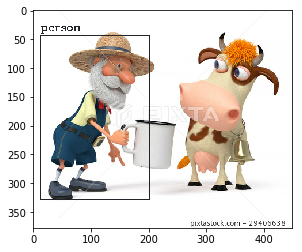

In [47]:
fontFace = cv2.FONT_HERSHEY_COMPLEX 
fontScale = 0.6 
#fontcolor = (0, 255, 0) # BGR 
thickness = 1 
lineType = 4

for i in range(len(box)):
    cv2.rectangle(image_run[0], box[i][0], box[i][1], category_colors[category[i]],0)
    cv2.putText(image_run[0], category[i], (box[i][0][0], box[i][0][1]-8), \
                fontFace, fontScale, category_colors[category[i]], thickness, lineType)

plt.imshow(image_run[0])

In [48]:
box_by_category

{'person': [([(13, 44), (202, 328)], 0.53990763, 0.969812)]}

In [49]:
nmx_threshold=0.2
box_by_category_nmx = {}
for key in box_by_category:
    nmx_box = sorted(box_by_category[key], key=lambda x:x[1], reverse=True)
    start_index = 0
    dropped_index = []
    while True:
        if start_index >= len(nmx_box):
            break
        if start_index in dropped_index:
            start_index += 1
            continue
        rect1 = nmx_box[start_index][0]  #The rect include [(xmin,ymin), (xmax,ymax)]
        for i in range((start_index+1),len(nmx_box)):
            if i not in dropped_index:
                rect2 = nmx_box[i][0]
                iou = IOU_calculate(rect1, rect2)
                if iou > nmx_threshold:
                    dropped_index.append(i)
        start_index += 1
        
    box_by_category_nmx[key]=[]
    for i in range(len(nmx_box)):
        if i not in dropped_index:
            box_by_category_nmx[key].append(nmx_box[i])

In [50]:
box_by_category_nmx

{'person': [([(13, 44), (202, 328)], 0.53990763, 0.969812)]}

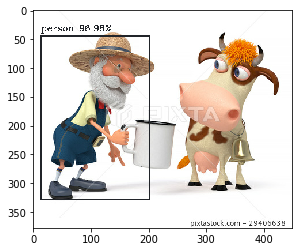

In [51]:
fontFace = cv2.FONT_HERSHEY_COMPLEX 
fontScale = 0.5 
#fontcolor = (0, 0, 0) # BGR 
thickness = 1 
lineType = 1
for key in box_by_category_nmx:
    for i in range(len(box_by_category_nmx[key])):
        cv2.rectangle(image_copy[0], box_by_category_nmx[key][i][0][0], box_by_category_nmx[key][i][0][1], category_colors[key],2)
        probability = str(round(box_by_category_nmx[key][i][2]*100, 2))+"%"
        cv2.putText(image_copy[0], key+" "+probability, \
                    (box_by_category_nmx[key][i][0][0][0], box_by_category_nmx[key][i][0][0][1]-8), \
                    fontFace, fontScale, category_colors[key], thickness, lineType)
'''
for i in range(len(box_true)):
    cv2.rectangle(image_copy[0], box_true[i][0], box_true[i][1], (255,0,0),3)
'''
plt.imshow(image_copy[0])

In [35]:
cv_image = cv2.cvtColor(image_copy[0], cv2.COLOR_BGR2RGB)
cv2.imwrite("predict_image/car8_yolo_50000.jpg", cv_image)
cv2.imshow("image", cv_image)
if cv2.waitKey(10000):
    cv2.destroyAllWindows()
cv2.destroyAllWindows()